In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

In [3]:
# Load data
with np.load('cifar4-train.npz', allow_pickle=False) as data:
    cifar = dict(data.items())


In [5]:
# I split the data that I am going to use into train/test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    cifar['overfeat'], cifar['labels'], 
    stratify = cifar['labels'], test_size = 1000, random_state = 0)

# I do the same for the pixels to be able to query them later
x_train_px, x_test_px, y_train, y_test = train_test_split(
    cifar['pixels'], cifar['labels'], 
    stratify = cifar['labels'], test_size = 1000,random_state = 0)

In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
Logreg  =  SGDClassifier(
    # Set logistic loss
    loss='log',
    # Set max number of iterations and stopping criteria
    max_iter=1000, tol=1e-3, n_jobs = -1 # to use all cores
)

pca = PCA()

In [7]:
# one grid with a PCA step where i tune the alpha and the pca
grid =ParameterGrid({
    'logreg__alpha':[0.00001,0.0001,0.0005,0.001],
    'pca__n_components':np.arange(350,450,20)
    
})

#a second grid where i only tune the alpha as I wont use pca
grid1=ParameterGrid(
{
    'pca':[None],
    'logreg__alpha':[0.00001,0.0001,0.0005,0.001],

})

# Making lists to append the scores
val_scores_pca = []
val_scores = []

# The pipeline with the PCA as a step
pipe = Pipeline([
    ('pca',pca),
    ('logreg',Logreg)    
])


In [9]:
# Doing the grid search using the PCA pipe

for params_dict_pca in grid:
    pipe.set_params(**params_dict_pca)
    # 5-fold Cross-validation with n_jobs = -1 to use all the processors
    cv_results = cross_validate(pipe, x_train, y_train, cv=5, n_jobs=-1,
                                return_train_score=False)
    # Appending the criss-validation results in the previous dict to centralize
    params_dict_pca['mean val accuracy'] = cv_results['test_score'].mean()
    params_dict_pca['std of val accuracy'] = cv_results['test_score'].std()
    val_scores_pca.append(params_dict_pca)
    
# Doing the same for the grid without the PCA
for params_dict in grid1:
    pipe.set_params(**params_dict)
    
   
    cv_results = cross_validate(pipe, x_train, y_train, cv=5, n_jobs=-1,
                                return_train_score=False)

    params_dict['mean val accuracy'] = cv_results['test_score'].mean()
    params_dict['std of val accuracy'] = cv_results['test_score'].std()
    val_scores.append(params_dict)

In [10]:
# A DF with the hyperparameters and the results
scores_df = pd.DataFrame(val_scores)
scores_df = scores_df.sort_values(by='mean val accuracy',ascending = False)
scores_df = scores_df.reset_index(drop = True)
scores_df

,logreg__alpha,mean val accuracy,pca,std of val accuracy
0,0.00001,0.80700,None,0.022536
1,0.00010,0.80500,None,0.017518
2,0.00100,0.79550,None,0.013933
3,0.00050,0.79325,None,0.022425


In [11]:
# With the PCA
scores_df_pca = pd.DataFrame(val_scores_pca)
scores_df_pca = scores_df_pca.sort_values(by='mean val accuracy',ascending = False)
scores_df_pca = scores_df_pca.reset_index(drop = True)
scores_df_pca

,logreg__alpha,mean val accuracy,pca__n_components,std of val accuracy
0,0.00010,0.83700,430,0.012109
1,0.00100,0.83500,370,0.009779
2,0.00100,0.83475,410,0.008344
3,0.00010,0.83450,410,0.015744
4,0.00050,0.83450,350,0.015383
5,0.00100,0.83325,430,0.015342
6,0.00050,0.83250,370,0.013874
7,0.00010,0.83225,350,0.013951
8,0.00050,0.83225,410,0.014967
9,0.00050,0.83150,390,0.010106


In [12]:
# finding the best score from both DFs  and putting it in a dict
if scores_df['mean val accuracy'][0] > scores_df_pca['mean val accuracy'][0]:
    best_dict = {'pca':[None],
                 'alpha':scores_df['logreg__alpha'][0],
                 'accuracy':scores_df['mean val accuracy'][0],
                 'std':scores_df['std of val accuracy'][0]
                }
else:
    best_dict = {'pca':scores_df_pca['pca__n_components'][0],
                 'alpha':scores_df_pca['logreg__alpha'][0],
                 'accuracy':scores_df_pca['mean val accuracy'][0],
                 'std':scores_df_pca['std of val accuracy'][0]
                }

In [18]:
# fitting the best parameters
Logreg  =  SGDClassifier(
    # Set logistic loss
    loss='log',
    max_iter=1000, tol=1e-3, n_jobs = -1, alpha = best_dict['alpha']
    
)

pca = PCA(n_components=best_dict['pca'])

pipe_best = Pipeline([
    ('pca',pca),
    ('logreg',Logreg)    
])

pipe_best.fit(x_test,y_test)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=430, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logreg', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=0.001, verbose=0, warm_start=False))])

In [13]:
#printing the best results
print('Logistic Regression - top ccuracy across folds:',
      '{:.4f} (std: {:.4f}) with {} components and alpha {}'.format(
          best_dict['accuracy'],
          best_dict['std'],
          best_dict['pca'],
          best_dict['alpha']
          ))

Logistic Regression - top ccuracy across folds: 0.8370 (std: 0.0121) with 430 components and alpha 0.0001


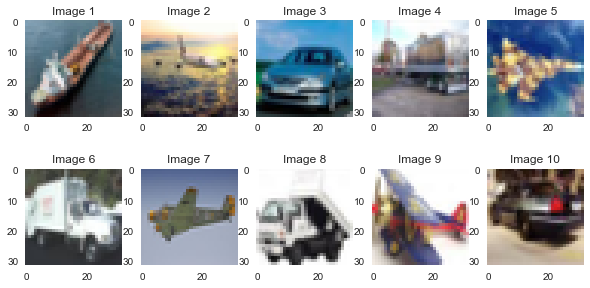

In [14]:
# plotting the first 10 imgs of the test set
# using the seperated pixels set
figs,axes = plt.subplots(nrows = 2, ncols =5 , figsize=(10,5)) 

for i, axis in enumerate(axes.flatten()):
    img_r = x_test_px[i].reshape(32,32,3)
    axis.imshow(img_r)
    axis.set_title('Image {}'.format(i+1))
    axis.grid(False)

plt.show()  

In [29]:
# calculating the probabilities for each class on these 10 images in a DF
pd.options.display.float_format = '{:,.2f}'.format
probs = pd.DataFrame(columns = cifar['names'],
                     data = pipe_best.predict_proba(x_test[0:10]))
probs

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


,truck,car,airplane,ship
0,0.00,0.00,0.49,0.51
1,0.00,0.00,0.50,0.50
2,0.00,0.50,0.50,0.00
3,1.00,0.00,0.00,0.00
4,0.00,0.00,0.50,0.50
5,1.00,0.00,0.00,0.00
6,0.00,0.00,1.00,0.00
7,0.50,0.50,0.00,0.00
8,0.00,0.00,1.00,0.00
9,0.00,1.00,0.00,0.00
